# 08. Рекомендательные системы

Содержание:
- Пример с данными
- Нейросетевой подход
- Библиотека Surprise
- Заключение
- Ссылки

# 1. Пример с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Генерация данных
def generate_movie_data():
    np.random.seed(42)
    
    # Создаем имитацию данных MovieLens
    users = [f'User{i}' for i in range(1, 6)]
    movies = ['The Matrix', 'Inception', 'Titanic', 'The Godfather', 'Pulp Fiction', 
              'Forrest Gump', 'The Dark Knight', 'Fight Club', 'The Shawshank Redemption', 'The Godfather II']
    
    # Создаем матрицу рейтингов (5 пользователей x 10 фильмов)
    ratings = np.zeros((len(users), len(movies)))
    
    # Заполняем некоторые оценки (имитируем разреженность)
    for i in range(len(users)):
        for j in range(len(movies)):
            if np.random.random() > 0.7:  # 30% заполненности
                ratings[i, j] = np.random.randint(1, 6)
    
    return users, movies, ratings

users, movies, ratings = generate_movie_data()
ratings_df = pd.DataFrame(ratings, index=users, columns=movies)
print("Матрица рейтингов:")
print(ratings_df)

Матрица рейтингов:
       The Matrix  Inception  Titanic  The Godfather  Pulp Fiction  \
User1         0.0        3.0      5.0            0.0           0.0   
User2         2.0        0.0      0.0            0.0           0.0   
User3         0.0        0.0      3.0            0.0           1.0   
User4         0.0        0.0      0.0            0.0           0.0   
User5         2.0        0.0      0.0            4.0           4.0   

       Forrest Gump  The Dark Knight  Fight Club  The Shawshank Redemption  \
User1           0.0              4.0         0.0                       0.0   
User2           0.0              0.0         0.0                       0.0   
User3           0.0              0.0         0.0                       0.0   
User4           0.0              0.0         3.0                       4.0   
User5           0.0              4.0         0.0                       0.0   

       The Godfather II  
User1               0.0  
User2               0.0  
User3        

# 2. Нейросетевой подход (Автоэнкодер)

Идея: Использовать автоэнкодер для предсказания предпочтений в матрице пользователь-товар

![](https://media.geeksforgeeks.org/wp-content/uploads/20251004153117008937/_how_does_it_work_.webp)

- **Вход:** Вектор, представляющий все взаимодействия одного пользователя (одна строка матрицы). Пропущенные значения обычно заполняются нулями.
- **Энкодер:** Сжимает этот вектор в плотный вектор низкой размерности (скрытое представление, *latent vector*). Этот вектор кодирует "профиль вкусов" пользователя.
- **Декодер:** Восстанавливает исходный вектор из скрытого представления, пытаясь предсказать все оценки, включая пропущенные.
- **Рекомендация:** После обучения, на выходе декодера получается "достроенная" матрица. Для каждого пользователя рекомендуются товары с самыми высокими предсказанными оценками, которые он еще не видел/не покупал.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

## Определение автоэнкодера

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_dim1, hidden_dim2, dropout_rate=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim1, input_size),
            nn.Sigmoid()  # Ограничиваем выход от 0 до 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Подготовка данных

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ratings_tensor = torch.FloatTensor(ratings).to(device)

# Масштабируем рейтинги от 0 до 1
ratings_scaled = ratings_tensor / 5.0

# Создаем маску для пропущенных значений (0 = пропущенный рейтинг)
mask = (ratings_tensor != 0).float().to(device)

## Настройки обучения

In [5]:
# Параметры модели
input_size = len(movies)
hidden_dim1 = 8
hidden_dim2 = 4
model = Autoencoder(input_size, hidden_dim1, hidden_dim2).to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

num_epochs = 2000

## Обучение модели

In [6]:
losses = []

for epoch in range(num_epochs):
    model.train()
    output = model(ratings_scaled)
    
    # Вычисляем потерю только для известных рейтингов
    loss = criterion(output * mask, ratings_scaled * mask)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

Epoch 0, Loss: 0.016771
Epoch 200, Loss: 0.001287
Epoch 400, Loss: 0.000476
Epoch 600, Loss: 0.000595
Epoch 800, Loss: 0.000445
Epoch 1000, Loss: 0.000728
Epoch 1200, Loss: 0.000457
Epoch 1400, Loss: 0.000090
Epoch 1600, Loss: 0.000406
Epoch 1800, Loss: 0.000281


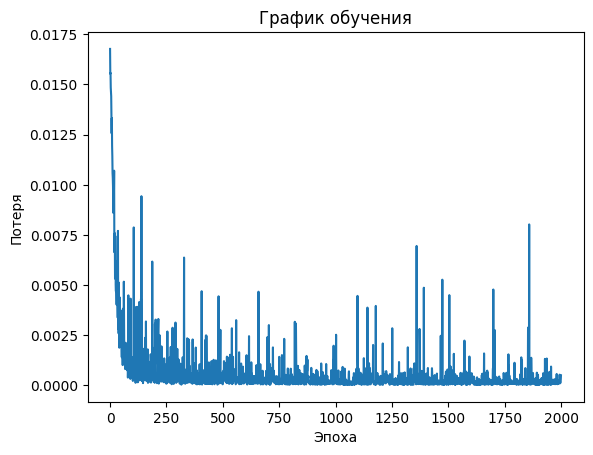

In [7]:
# Визуализация обучения
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('График обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

## Получение предсказаний

In [8]:
model.eval()
with torch.no_grad():
    predicted = model(ratings_scaled) * 5.0  # Возвращаем к шкале 1-5

# Создаем DataFrame с предсказаниями
predicted_ratings = predicted.cpu().numpy()
predicted_df = pd.DataFrame(predicted_ratings, index=users, columns=movies)

print("\nПредсказанные рейтинги:")
print(predicted_df.round(2))


Предсказанные рейтинги:
       The Matrix  Inception  Titanic  The Godfather  Pulp Fiction  \
User1        2.03       3.00     4.98           3.99          4.22   
User2        2.01       2.98     4.28           3.88          2.22   
User3        1.98       2.98     3.01           3.87          1.09   
User4        2.01       2.98     4.32           3.88          2.28   
User5        2.03       3.00     4.97           3.98          4.12   

       Forrest Gump  The Dark Knight  Fight Club  The Shawshank Redemption  \
User1           2.5             4.00        3.06                      4.14   
User2           2.5             3.98        3.00                      3.96   
User3           2.5             4.06        2.99                      3.96   
User4           2.5             3.98        3.00                      3.96   
User5           2.5             3.99        3.06                      4.12   

       The Godfather II  
User1              4.02  
User2              3.97  
User3  

## Рекомендации для пользователей

In [9]:
print("\nТоп-3 рекомендации для каждого пользователя:")
for user in users:
    user_ratings = predicted_df.loc[user]
    # Исключаем уже оцененные фильмы
    rated_movies = ratings_df.loc[user][ratings_df.loc[user] > 0].index
    recommendations = user_ratings.drop(rated_movies).nlargest(3)
    print(f"{user}: {list(recommendations.index)}")


Топ-3 рекомендации для каждого пользователя:
User1: ['Pulp Fiction', 'The Shawshank Redemption', 'The Godfather II']
User2: ['Titanic', 'The Dark Knight', 'The Godfather II']
User3: ['The Dark Knight', 'The Shawshank Redemption', 'The Godfather']
User4: ['Titanic', 'The Dark Knight', 'The Godfather II']
User5: ['Titanic', 'The Shawshank Redemption', 'The Godfather II']


# 3. Библиотека Surprise

[Surprise](https://github.com/NicolasHug/Surprise?tab=readme-ov-file) $-$ библиотека для коллаборативной фильтрации

![](https://github.com/NicolasHug/Surprise/raw/master/logo_black.svg/)

Используем алгоритм _матричной факторизации_ SVD.

Пусть у нас есть матрица предпочтений.
SVD $-$ это математический способ пребразовать матрицу и найти **скрытые предпочтения**.

In [10]:
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

def surprise_demo():
    """
    Демонстрация использования библиотеки Surprise
    """
    # Подготовка данных в формате Surprise
    ratings_data = []
    for user_idx, user in enumerate(users):
        for movie_idx, movie in enumerate(movies):
            rating = ratings[user_idx, movie_idx]
            if rating > 0:
                ratings_data.append({'user': user, 'item': movie, 'rating': rating})
    
    df = pd.DataFrame(ratings_data)
    
    # Определяем формат рейтингов
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)
    
    # Используем алгоритм SVD
    algo = SVD()
    
    # Кросс-валидация
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    # Обучаем на всех данных и делаем предсказания
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    
    # Предсказание для конкретной пары пользователь-фильм
    test_user = 'User1'
    test_movie = 'The Godfather'
    prediction = algo.predict(test_user, test_movie)
    
    print(f"\nПредсказание для {test_user} и {test_movie}: {prediction.est:.2f}")
    
    return algo, results

algo, results = surprise_demo()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1936  0.9159  1.1006  1.0700  0.1154  
MAE (testset)     0.9508  0.9041  0.9092  0.9214  0.0209  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    

Предсказание для User1 и The Godfather: 3.61


# 4. Заключение

| Метод | Преимущества | Недостатки | Лучшие сценарии применения |
|-------|-------------|------------|---------------------------|
| **User-Based CF** | Простота реализации, находит неочевидные связи | Вычислительная сложность, холодный старт | Системы с устойчивыми сообществами пользователей |
| **Item-Based CF** | Стабильность, быстрый онлайн-расчет | Требует много памяти для хранения схожестей | Каталоги с устойчивыми ассоциациями товаров |
| **Content-Based** | Решает холодный старт, прозрачность рекомендаций | Ограниченность, требует метаданные | Нишевые сервисы, новые пользователи/товары |
| **Нейросетевые подходы** | Высокая точность, гибкость | Сложность реализации, требуют много данных | Крупные платформы с большим объемом данных |


Рекомендации по выбору метода

1. **Для начинающих**: начните с Item-Based CF или простых матричных разложений
2. **При наличии метаданных**: используйте гибридные подходы, сочетающие CF и content-based методы
3. **Для крупных систем**: рассмотрите нейросетевые подходы
4. **При проблеме холодного старта**: добавьте content-based компонент или используйте популярные товары

# Ссылки для дальнейшего изучения

- [Surprise](https://surpriselib.com/) $-$ библиотека для коллаборативной фильтрации
- [LightFM](https://github.com/lyst/lightfm) $-$ библиотека для гибридных рекомендаций
- [MovieLens](https://grouplens.org/datasets/movielens/) $-$ датасет MovieLens